In [22]:
import numpy as np
import tensorflow as tf
import tensorflow.data as tfd
import pandas as pd
import json
import os

In [23]:
IMG_WIDTH = 200
IMG_HEIGHT = 50
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 8
EPOCHS = 150
LEARNING_RATE = 1e-3
MODEL_NAME = "CharacterRecognition-Model"
TRAIN_SIZE = BATCH_SIZE * 3000
VALID_SIZE = BATCH_SIZE * 1500
TEST_SIZE  = BATCH_SIZE * 300
AUTOTUNE = tfd.AUTOTUNE

# Paths 
img_path = '../dataset/img'
test_json_path = '../dataset/split/test.json'
val_json_path = '../dataset/split/val.json'
train_json_path = '../dataset/split/train.json'

# SetUp random seeds for numpy and TensorFlow
np.random.seed(2569)
tf.random.set_seed(2569)

In [24]:
# Load the json files and transform into dataframes

def json_to_csv(json_path):
    # Load the JSON file
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Convert the data to a pandas DataFrame
    return pd.DataFrame(data)
    

# Convert the JSON files to CSV
test_csv = json_to_csv(test_json_path)[:TEST_SIZE]
valid_csv = json_to_csv(val_json_path)[:VALID_SIZE]
train_csv = json_to_csv(train_json_path)[:TRAIN_SIZE]

In [25]:
test_csv.head()

,decade_id,height,img,nameset,text,width
0,1,96,002_07_00.jpg,test,troppo grasso di porco. È necessario ancora,1338
1,1,69,002_07_01.jpg,test,"lo star allegro il più che si può, e non faticar",1382
2,1,81,002_07_02.jpg,test,alle volte più di quello che portano le forze,1307
3,1,86,002_07_03.jpg,test,naturali: il troppo poco ancor egli genera,1276
4,1,86,002_07_04.jpg,test,illusioni.,287


In [26]:
# get the train labels 
train_labels = [str(word) for word in train_csv["text"].to_numpy()]

# extract all the unique characters
unique_characters = set(char for word in train_labels for char in word)
# define the number of classes (for labels) based on the number of unique characters
n_classes = len(unique_characters)

MAX_LABEL_LENGTH = max(map(len, train_labels))

In [27]:
def add_file_path(df):
    df['file_name'] = df['img'].apply(lambda x: "../dataset/img/" + x)
    return df

def drop_unnecessary_columns(df):
    return df.drop(columns=['decade_id', 'nameset'])

def transform_pipeline(df):
    return add_file_path(drop_unnecessary_columns(df))

train_csv = transform_pipeline(train_csv)
valid_csv = transform_pipeline(valid_csv)
test_csv = transform_pipeline(test_csv)

In [28]:
test_csv.head()

,height,img,text,width,file_name
0,96,002_07_00.jpg,troppo grasso di porco. È necessario ancora,1338,../dataset/img/002_07_00.jpg
1,69,002_07_01.jpg,"lo star allegro il più che si può, e non faticar",1382,../dataset/img/002_07_01.jpg
2,81,002_07_02.jpg,alle volte più di quello che portano le forze,1307,../dataset/img/002_07_02.jpg
3,86,002_07_03.jpg,naturali: il troppo poco ancor egli genera,1276,../dataset/img/002_07_03.jpg
4,86,002_07_04.jpg,illusioni.,287,../dataset/img/002_07_04.jpg


In [29]:
from keras.src.layers import StringLookup

# Char to Num
char_to_num = StringLookup(vocabulary=list(unique_characters), mask_token=None)
num_to_char = StringLookup(vocabulary = char_to_num.get_vocabulary(), mask_token = None, invert = True)

In [30]:
def load_image(image_path):
    """
    This function gets the image path and 
    reads the image using TensorFlow, Then the image will be decoded and 
    will be converted to float data type. next resize and transpose will be applied to it.
    In the final step the image will be converted to a Numpy Array using tf.cast
    """
    # read the image
    image = tf.io.read_file(image_path)
    # decode the image
    decoded_image = tf.image.decode_jpeg(contents=image, channels=1)
    # convert image data type to float32
    convert_imgs = tf.image.convert_image_dtype(image=decoded_image, dtype=tf.float32)
    # resize and transpose 
    resized_image = tf.image.resize(images=convert_imgs, size=(IMG_HEIGHT, IMG_WIDTH))
    image = tf.transpose(resized_image, perm = [1, 0, 2])

    # to numpy array (Tensor)
    image_array = tf.cast(image, dtype=tf.float32)

    return image_array

In [31]:
def encode_single_sample(image_path, label:str):
    # Get the image
    image = load_image(image_path)
    # Convert the label into characters
    chars = tf.strings.unicode_split(label, input_encoding='UTF-8')
    # Convert the characters into vectors
    vecs = char_to_num(chars)

    # Pad label
    pad_size = MAX_LABEL_LENGTH - tf.shape(vecs)[0]
    vecs = tf.pad(vecs, paddings = [[0, pad_size]], constant_values=n_classes+1)

    return {'image':image, 'label':vecs}

In [32]:
# Training Data
train_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(train_csv['file_name'].to_list()), np.array(train_csv['text'].to_list()))
).shuffle(1000).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Validation data
valid_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(valid_csv['file_name'].to_list()), np.array(valid_csv['text'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Testing data.
test_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(test_csv['file_name'].to_list()), np.array(test_csv['text'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [33]:
# check the data distribution 
print(f"Training Data Size   : {tf.data.Dataset.cardinality(train_ds).numpy() * BATCH_SIZE}")
print(f"Validation Data Size : {tf.data.Dataset.cardinality(valid_ds).numpy() * BATCH_SIZE}")
print(f"Testing Data Size    : {tf.data.Dataset.cardinality(test_ds).numpy() * BATCH_SIZE}")

Training Data Size   : 19832
Validation Data Size : 2472
Testing Data Size    : 2400


In [34]:
import matplotlib.pyplot as plt
from IPython.display import clear_output as cls


def show_images(data, GRID=[4,4], FIGSIZE=(25, 8), cmap='binary_r', model=None, decode_pred=None):
    
    # Plotting configurations
    plt.figure(figsize=FIGSIZE)
    n_rows, n_cols = GRID
    
    # Loading Data 
    data = next(iter(data))
    images, labels = data['image'], data['label']
    
    # Iterate over the data 
    for index, (image, label) in enumerate(zip(images, labels)):
        
        # Label processing
        text_label = num_to_char(label)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()
        
        # Create a sub plot
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(tf.transpose(image, perm=[1,0,2]), cmap=cmap)
        plt.axis('off')
        
        if model is not None and decode_pred is not None:
            # Make prediction
            pred = model.predict(tf.expand_dims(image, axis=0))
            pred = decode_pred(pred)[0]
            title = f"True : {text_label}\nPred : {pred}"
            plt.title(title)
        else:
            # add title
            plt.title(text_label)

    # Show the final plot
    cls()
    plt.show()

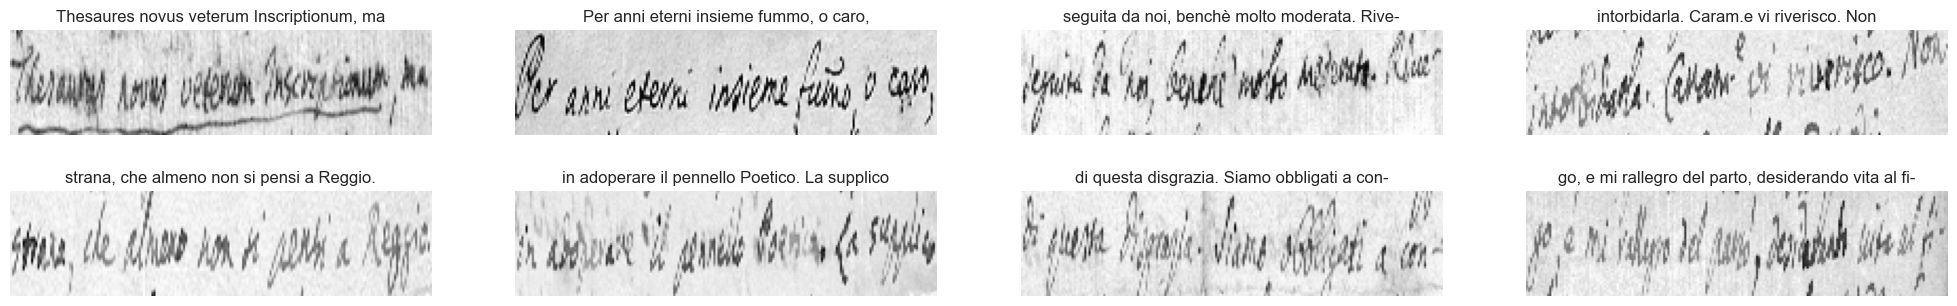

In [35]:
show_images(data=train_ds, cmap='gray')